### Code to create Fig. 1 in Main Text

This code produces a bivariate map using two variables: undernourishment and wheat import dependence. 

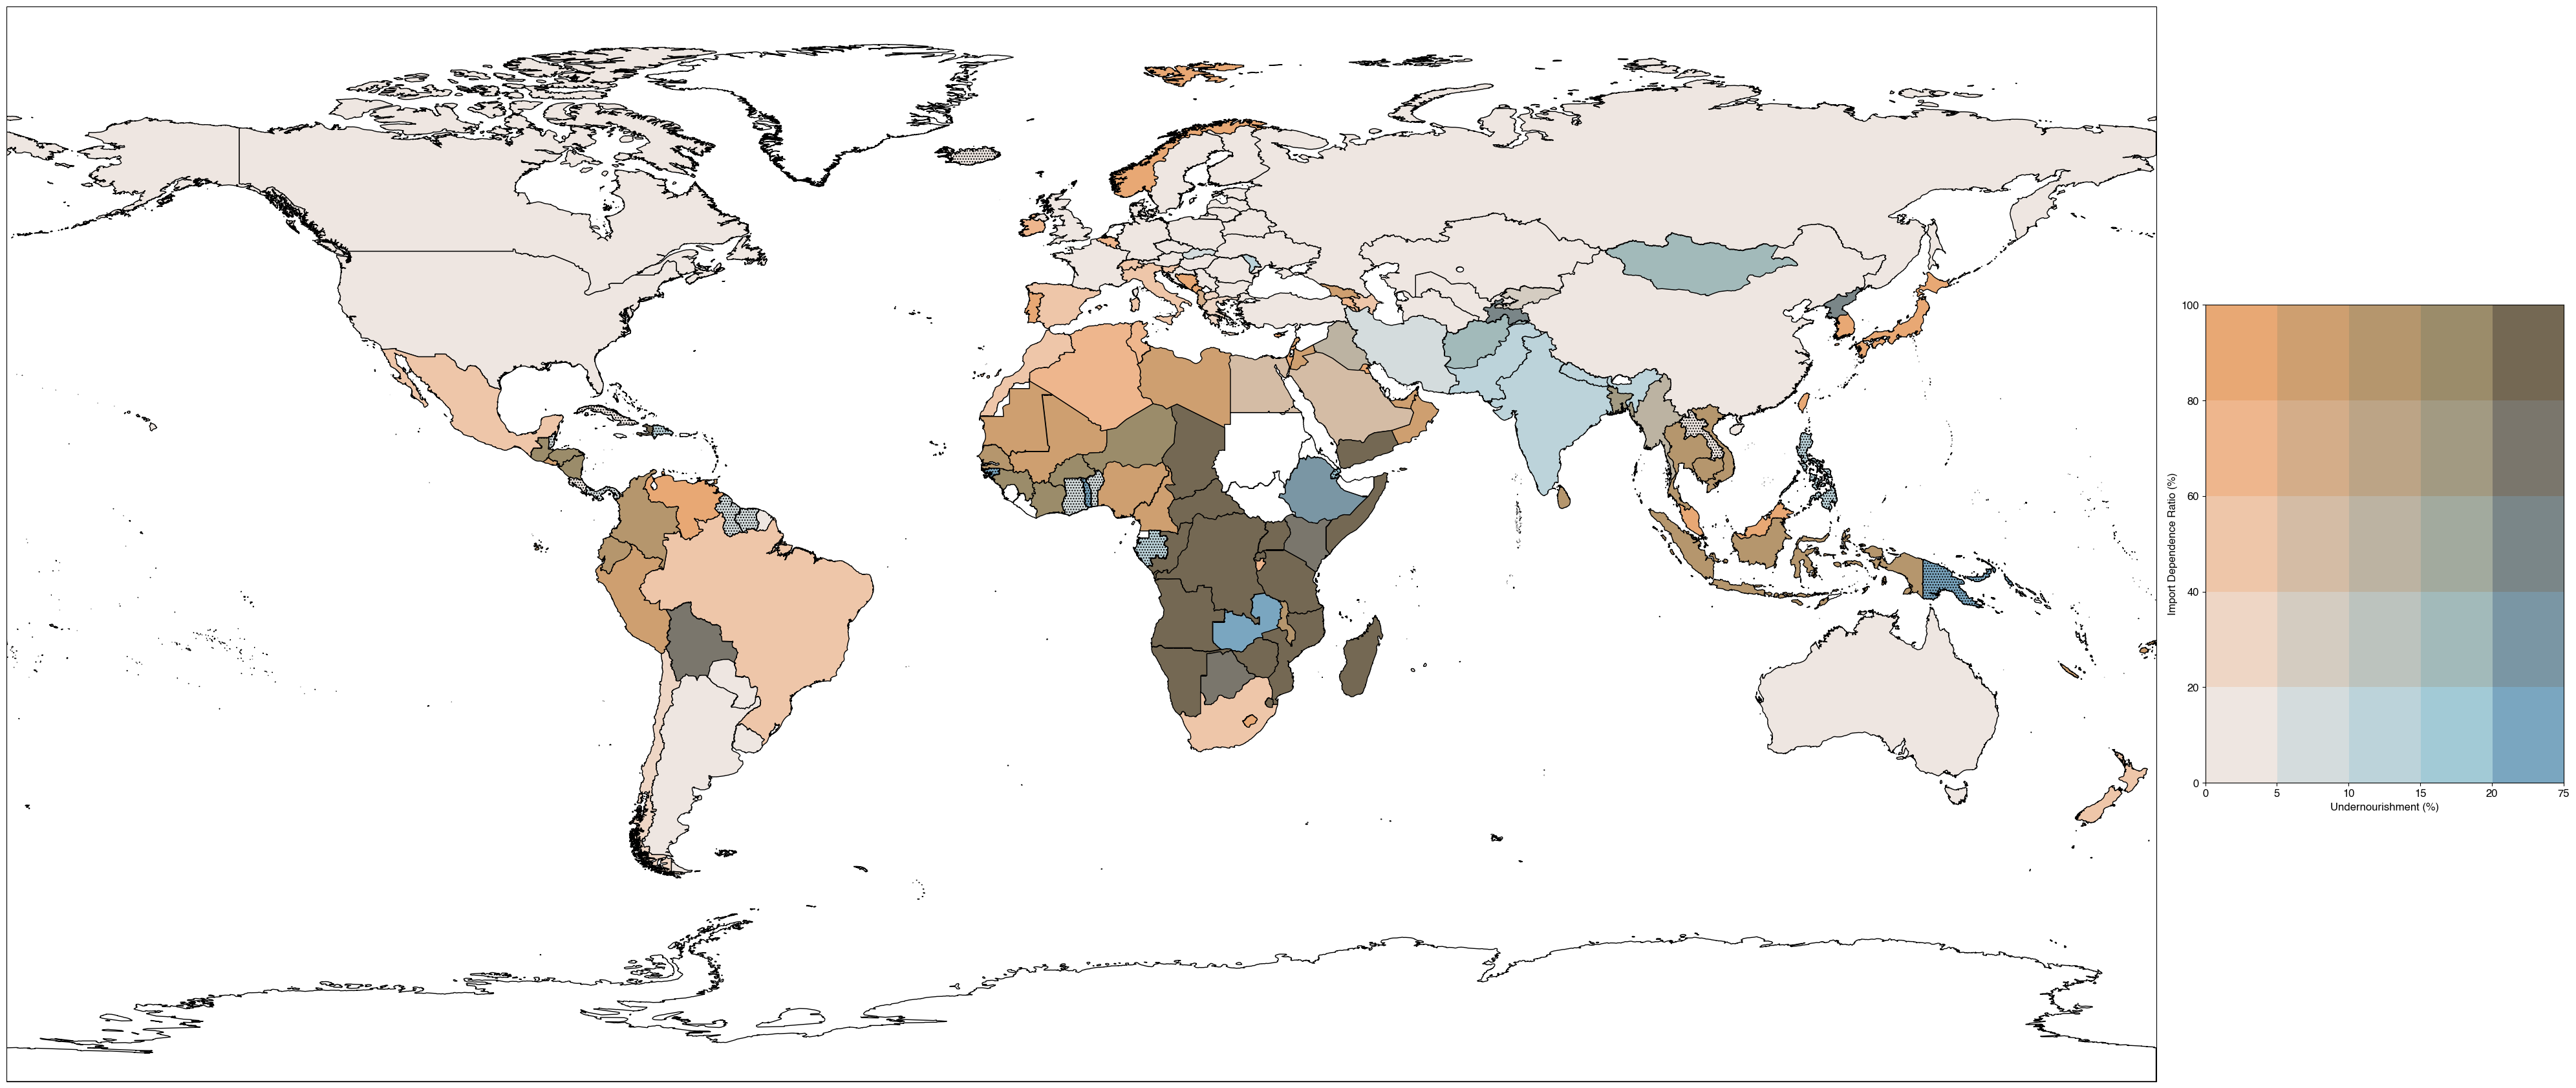

In [62]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

# Read data
df = pd.read_excel('data/figure-data.xlsx', sheet_name='data')
high_res_world = gpd.read_file('data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')

# Error handling
try:
    df = pd.read_excel('data/figure-data.xlsx', sheet_name='data')
except FileNotFoundError:
    print("Error: The file 'figure-data.xlsx' was not found.")
    # Handle the error or exit

try:
    high_res_world = gpd.read_file('data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
except FileNotFoundError:
    print("Error: The shapefile was not found.")
    # Handle the error or exit

# Set global font properties
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.style'] = 'normal'

# Define the cutoffs for x and y values
x_cutoffs = [0, 5, 10, 15, 20, 75]  # For Undernourishment
y_cutoffs = [0, 20, 40, 60, 80, 100]  # For Wheat Import Dependence

def blend_colors(color1, color2, ratio):
    """
    Blends two colors given a ratio.

    Parameters:
    color1 (str): The first color in hex format (e.g., '#ff0000').
    color2 (str): The second color in hex format (e.g., '#0000ff').
    ratio (float): The ratio to blend the colors (0.0 to 1.0).

    Returns:
    str: The blended color in hex format.
    """
    r1, g1, b1 = int(color1[1:3], 16), int(color1[3:5], 16), int(color1[5:], 16)
    r2, g2, b2 = int(color2[1:3], 16), int(color2[3:5], 16), int(color2[5:], 16)
    r = round(r1 * (1 - ratio) + r2 * ratio)
    g = round(g1 * (1 - ratio) + g2 * ratio)
    b = round(b1 * (1 - ratio) + b2 * ratio)
    return f'#{r:02x}{g:02x}{b:02x}'

# Create custom colours for the bivariate map
def generate_bivariate_cmap(blending_ratio=0.5):
    """
    Generates a bivariate colormap with defined scales.
    Blues represent Undernourishment and oranges represent Wheat Import Dependence.

    Parameters:
    blending_ratio (float): The ratio to blend the colors (0.0 to 1.0).

    Returns:
    ListedColormap: The generated bivariate colormap.
    """
    blue_scale = ['#e8e8e8', '#b5d6e0', '#83c3da', '#4fb0d3', '#0069A6']  # X-axis blues (Undernourishment)
    orange_scale = ['#f4e3da', '#f4c3a2', '#f4a36a', '#f48432', '#E76800']  # Y-axis oranges (Wheat Import Dependence)

    color_scale = []
    for i in range(len(orange_scale)):
        for j in range(len(blue_scale)):
            # Blend colors to create a bivariate color map
            blended_color = blend_colors(orange_scale[i], blue_scale[j], blending_ratio)
            color_scale.append(blended_color)
    return mcolors.ListedColormap(color_scale)

# Create the bivariate colormap
cmap = generate_bivariate_cmap()

def map_values_to_colors(IDR, Undernourishment, x_cutoffs, y_cutoffs, cmap):
    """
    Maps the data values to the appropriate colors in the bivariate colormap.

    Parameters:
    IDR (array-like): The IDR values.
    Undernourishment (array-like): The Undernourishment values.
    x_cutoffs (list): The cutoffs for the x-axis.
    y_cutoffs (list): The cutoffs for the y-axis.
    cmap (ListedColormap): The bivariate colormap.

    Returns:
    array-like: The mapped colors.
    """
    x_bin_index = np.digitize(Undernourishment, x_cutoffs, right=True) - 1
    y_bin_index = np.digitize(IDR, y_cutoffs, right=True) - 1

    # Ensure the indices are within the valid range
    x_bin_index = np.clip(x_bin_index, 0, len(x_cutoffs) - 2)
    y_bin_index = np.clip(y_bin_index, 0, len(y_cutoffs) - 2)

    index = y_bin_index * (len(x_cutoffs) - 1) + x_bin_index
    return cmap(index)

# Apply the color mapping to the dataframe
df['color'] = df.apply(lambda row: map_values_to_colors(row['IDR'], row['Undernourishment'], x_cutoffs, y_cutoffs, cmap), axis=1)

### CHECK colour assigment output ###
# First: convert RGB to Hex
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % (int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

df['color_hex'] = df['color'].apply(lambda c: rgb_to_hex(mcolors.to_rgba(c)))

# Second: write the output to an Excel file
df_color_output = df[['Country', 'Undernourishment', 'IDR', 'color_hex']]
df_color_output.to_excel('outputs/2010-country_colors.xlsx', index=False)

### END CHECK ###

### PLOTTING ###
# Merge the color data with the world map data
high_res_world = high_res_world.merge(df[['Country', 'color_hex', 'IDR', 'Undernourishment', 'no_Undernourishment', 'no_IDR']], left_on='NAME', right_on='Country', how='left')

# Add hatching patterns based on conditions
high_res_world['hatch'] = high_res_world['no_Undernourishment'].apply(lambda a: '//////' if a == 0 else '')
high_res_world['dots'] = high_res_world['no_IDR'].apply(lambda a: '....' if a == 0 else '')

# Set parameters for the figure
fig = plt.figure(figsize=(40, 20))
gs = fig.add_gridspec(1, 2, width_ratios=[6, 1])
main_ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())

# Add country colours
for _, row in high_res_world.iterrows():
    facecolor = row['color_hex'] if pd.notnull(row['color_hex']) else 'white'
    main_ax.add_geometries([row['geometry']], ccrs.PlateCarree(), facecolor=facecolor, edgecolor='black', linewidth=1)

# Add hatches
for _, row in high_res_world.iterrows():
    hatch = row['hatch'] + row['dots']
    if hatch:  # Only apply hatching if there is a pattern
        main_ax.add_geometries([row['geometry']], ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, hatch=hatch)

# Create the legend as a grid for bivariate mapping
legend_ax = fig.add_subplot(gs[1])
x_intervals = np.array(x_cutoffs)
y_intervals = np.array(y_cutoffs)
cz = np.zeros((len(y_intervals) - 1, len(x_intervals) - 1))

for yi in range(len(y_intervals) - 1):
    for xi in range(len(x_intervals) - 1):
        index = yi * (len(x_intervals) - 1) + xi
        cz[yi, xi] = index

grid_legend = legend_ax.imshow(cz, cmap=cmap, interpolation='none', origin='lower',
                               extent=[x_intervals[0], x_intervals[-1], y_intervals[0], y_intervals[-1]])

# Manually set the tick positions and labels to reflect the non-linear scale
legend_ax.set_xticks(np.linspace(x_intervals[0], x_intervals[-1], len(x_cutoffs)))
legend_ax.set_yticks(np.linspace(y_intervals[0], y_intervals[-1], len(y_cutoffs)))
legend_ax.set_xticklabels(x_cutoffs)
legend_ax.set_yticklabels(y_cutoffs)

# Add legend labels
legend_ax.set_xlabel('Undernourishment (%)')
legend_ax.set_ylabel('Import Dependence Ratio (%)')
main_ax.set_axis_on()

plt.tight_layout()
plt.show()

### END PLOTTING ###

### SAVE FIGURE ###
# Options for saving the figure in different formats. Uncomment the desired format.

# fig.savefig('outputs/figure.svg', format='svg')
fig.savefig('outputs/figure.jpeg', dpi=300)
# fig.savefig('outputs/figure.png', dpi=300)

### END SAVE FIGURE ###

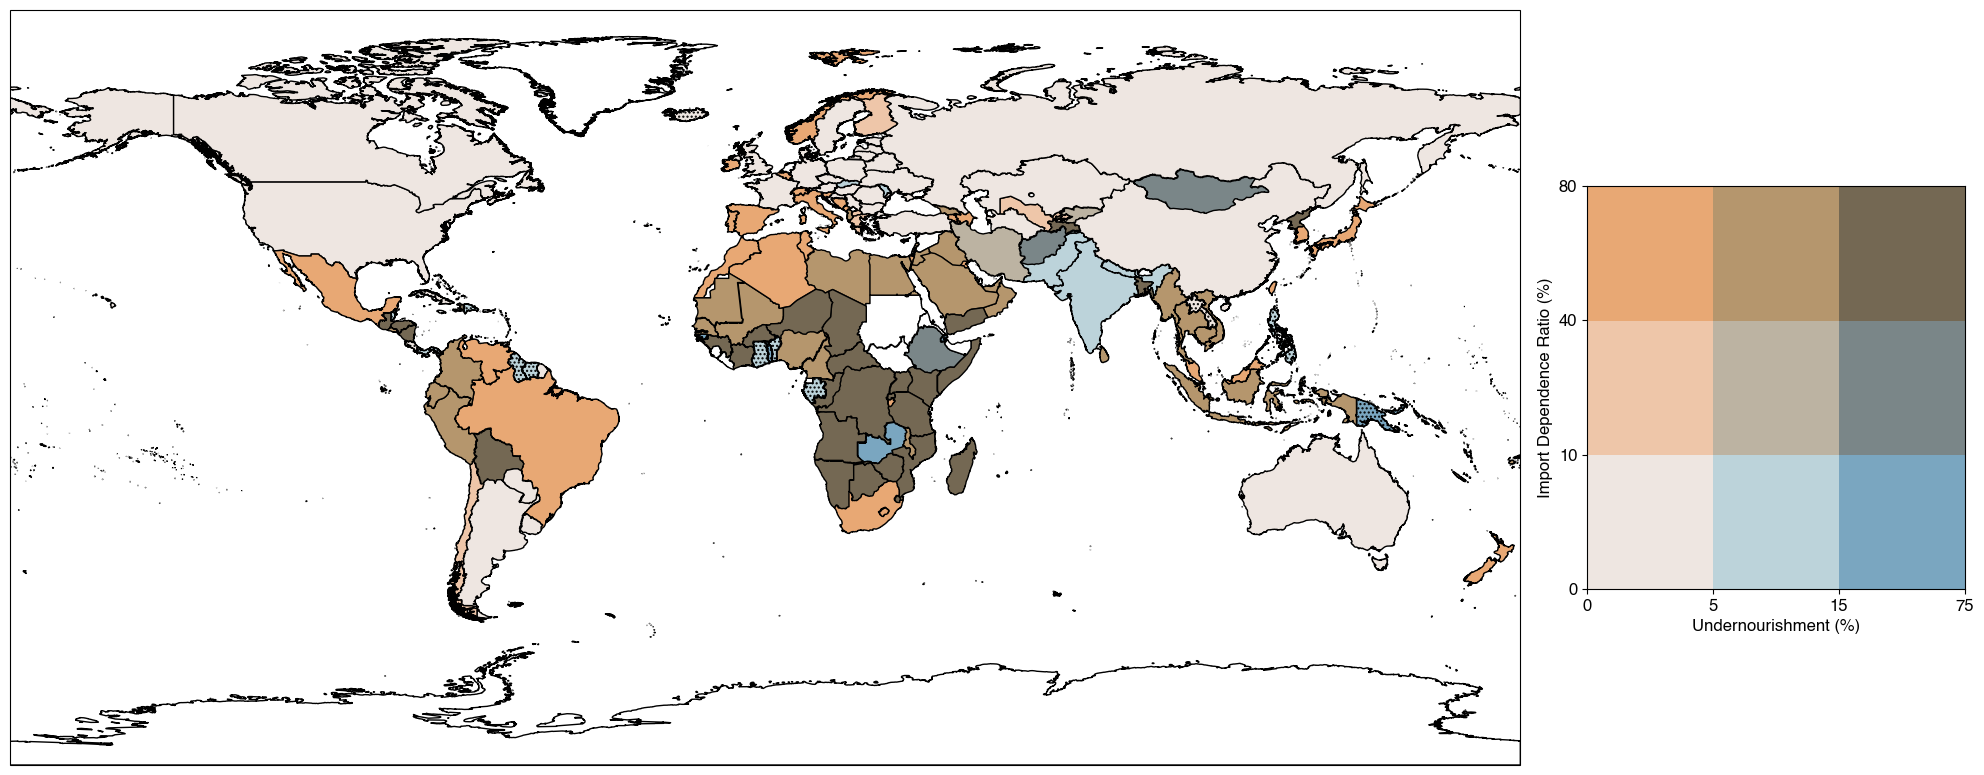

In [67]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

# Read data
try:
    df = pd.read_excel('data/figure-data.xlsx', sheet_name='data')
except FileNotFoundError:
    print("Error: The file 'figure-data.xlsx' was not found.")
    # Handle the error or exit

try:
    high_res_world = gpd.read_file('data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
except FileNotFoundError:
    print("Error: The shapefile was not found.")
    # Handle the error or exit

# Set global font properties
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.style'] = 'normal'

# Define the cutoffs for x and y values
x_cutoffs = [0, 5, 10, 20]  # For Undernourishment
y_cutoffs = [0, 10, 40, 80]  # For Wheat Import Dependence

def blend_colors(color1, color2, ratio):
    """
    Blends two colors given a ratio.

    Parameters:
    color1 (str): The first color in hex format (e.g., '#ff0000').
    color2 (str): The second color in hex format (e.g., '#0000ff').
    ratio (float): The ratio to blend the colors (0.0 to 1.0).

    Returns:
    str: The blended color in hex format.
    """
    r1, g1, b1 = int(color1[1:3], 16), int(color1[3:5], 16), int(color1[5:], 16)
    r2, g2, b2 = int(color2[1:3], 16), int(color2[3:5], 16), int(color2[5:], 16)
    r = round(r1 * (1 - ratio) + r2 * ratio)
    g = round(g1 * (1 - ratio) + g2 * ratio)
    b = round(b1 * (1 - ratio) + b2 * ratio)
    return f'#{r:02x}{g:02x}{b:02x}'

## Define the cutoffs for x and y values
x_cutoffs = [0, 5, 15, 75]  # For Undernourishment
y_cutoffs = [0, 10, 40, 80]  # For Wheat Import Dependence

def blend_colors(color1, color2, ratio):
    """
    Blends two colors given a ratio.

    Parameters:
    color1 (str): The first color in hex format (e.g., '#ff0000').
    color2 (str): The second color in hex format (e.g., '#0000ff').
    ratio (float): The ratio to blend the colors (0.0 to 1.0).

    Returns:
    str: The blended color in hex format.
    """
    r1, g1, b1 = int(color1[1:3], 16), int(color1[3:5], 16), int(color1[5:], 16)
    r2, g2, b2 = int(color2[1:3], 16), int(color2[3:5], 16), int(color2[5:], 16)
    r = round(r1 * (1 - ratio) + r2 * ratio)
    g = round(g1 * (1 - ratio) + g2 * ratio)
    b = round(b1 * (1 - ratio) + b2 * ratio)
    return f'#{r:02x}{g:02x}{b:02x}'

# Create custom colours for the bivariate map
def generate_bivariate_cmap(blending_ratio=0.5):
    """
    Generates a bivariate colormap with defined scales.
    Blues represent Undernourishment and oranges represent Wheat Import Dependence.

    Parameters:
    blending_ratio (float): The ratio to blend the colors (0.0 to 1.0).

    Returns:
    ListedColormap: The generated bivariate colormap.
    """
    
    blue_scale = ['#e8e8e8', '#83c3da', '#0069A6']  # X-axis blues (Undernourishment)
    orange_scale = ['#f4e3da', '#f4a36a', '#E76800']  # Y-axis oranges (Wheat Import Dependence)

    color_scale = []
    for i in range(len(orange_scale)):
        for j in range(len(blue_scale)):
            # Blend colors to create a bivariate color map
            blended_color = blend_colors(orange_scale[i], blue_scale[j], blending_ratio)
            color_scale.append(blended_color)
    return mcolors.ListedColormap(color_scale)

# Create the bivariate colormap with specified colors
cmap = generate_bivariate_cmap()

def map_values_to_colors(IDR, Undernourishment, x_cutoffs, y_cutoffs, cmap):
    """
    Maps the data values to the appropriate colors in the bivariate colormap.

    Parameters:
    IDR (array-like): The IDR values.
    Undernourishment (array-like): The Undernourishment values.
    x_cutoffs (list): The cutoffs for the x-axis.
    y_cutoffs (list): The cutoffs for the y-axis.
    cmap (ListedColormap): The bivariate colormap.

    Returns:
    array-like: The mapped colors.
    """
    x_bin_index = np.digitize(Undernourishment, x_cutoffs, right=True) - 1
    y_bin_index = np.digitize(IDR, y_cutoffs, right=True) - 1

    # Ensure the indices are within the valid range
    x_bin_index = np.clip(x_bin_index, 0, len(x_cutoffs) - 2)
    y_bin_index = np.clip(y_bin_index, 0, len(y_cutoffs) - 2)

    index = y_bin_index * (len(x_cutoffs) - 1) + x_bin_index
    return cmap(index)

# Apply the color mapping to the dataframe
df['color'] = df.apply(lambda row: map_values_to_colors(row['IDR'], row['Undernourishment'], x_cutoffs, y_cutoffs, cmap), axis=1)

### CHECK colour assigment output ###
# First: convert RGB to Hex
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % (int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

df['color_hex'] = df['color'].apply(lambda c: rgb_to_hex(mcolors.to_rgba(c)))

# Second: write the output to an Excel file
df_color_output = df[['Country', 'Undernourishment', 'IDR', 'color_hex']]
df_color_output.to_excel('outputs/2010-country_colors.xlsx', index=False)

### END CHECK ###

### PLOTTING ###
# Merge the color data with the world map data
high_res_world = high_res_world.merge(df[['Country', 'color_hex', 'IDR', 'Undernourishment', 'no_Undernourishment', 'no_IDR']], left_on='NAME', right_on='Country', how='left')

# Add hatching patterns based on conditions
high_res_world['hatch'] = high_res_world['no_Undernourishment'].apply(lambda a: '//////' if a == 0 else '')
high_res_world['dots'] = high_res_world['no_IDR'].apply(lambda a: '....' if a == 0 else '')

# Set parameters for the figure
fig = plt.figure(figsize=(20, 10))  # Adjust the figure size to make it more square
gs = fig.add_gridspec(1, 2, width_ratios=[4, 1])  # Adjust the width ratios
main_ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())

# Add country colours
for _, row in high_res_world.iterrows():
    facecolor = row['color_hex'] if pd.notnull(row['color_hex']) else 'white'
    main_ax.add_geometries([row['geometry']], ccrs.PlateCarree(), facecolor=facecolor, edgecolor='black', linewidth=1)

# Add hatches
for _, row in high_res_world.iterrows():
    hatch = row['hatch'] + row['dots']
    if hatch:  # Only apply hatching if there is a pattern
        main_ax.add_geometries([row['geometry']], ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, hatch=hatch)

# Create the legend as a grid for bivariate mapping
legend_ax = fig.add_subplot(gs[1])

# Create a fixed 3x3 grid for the legend
x_intervals = np.array(x_cutoffs)
y_intervals = np.array(y_cutoffs)
cz = np.zeros((3, 3))  # 3x3 grid for 3 categories each

# Fill the grid with indices (0-8 for 9 cells)
for yi in range(3):
    for xi in range(3):
        index = yi * 3 + xi
        cz[yi, xi] = index

# Display the legend grid with fixed square aspect ratio
grid_legend = legend_ax.imshow(cz, cmap=cmap, interpolation='none', origin='lower',
                               extent=[x_intervals[0], x_intervals[-1], y_intervals[0], y_intervals[-1]],
                               aspect='auto')  # Force square cells

# Manually set the tick positions and labels to reflect the non-linear scale
legend_ax.set_xticks(np.linspace(x_intervals[0], x_intervals[-1], len(x_cutoffs)))
legend_ax.set_yticks(np.linspace(y_intervals[0], y_intervals[-1], len(y_cutoffs)))
legend_ax.set_xticklabels(x_cutoffs)
legend_ax.set_yticklabels(y_cutoffs)

# Add legend labels
legend_ax.set_xlabel('Undernourishment (%)')
legend_ax.set_ylabel('Import Dependence Ratio (%)')

# Ensure the legend is a square
legend_ax.set_aspect('equal', 'box')

plt.tight_layout()
plt.show()

### END PLOTTING ###

### SAVE FIGURE ###
# Options for saving the figure in different formats. Uncomment the desired format.

# fig.savefig('outputs/figure.svg', format='svg')
fig.savefig('outputs/figure.jpeg', dpi=300)
# fig.savefig('outputs/figure.png', dpi=300)